In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
#import netCDF4 as nc
import scipy.spatial as sp
import wradlib.georef as georef
import wradlib
import datetime as dt
import xarray as xr
import rasterio
import rasterio.mask as riom
import tarfile
import sys
import glob
import xarray as xr
import tarfile

In [2]:
locs = pd.read_csv("data/locs/14_Sep_Matrix_UTM_WGS84.csv", sep=",")
locs = gpd.GeoDataFrame(locs, geometry=gpd.points_from_xy(locs.E, locs.N), crs="EPSG:32632").to_crs("EPSG:4326")

In [3]:
xy = np.array([locs.geometry.x,locs.geometry.y]).T
xy.shape

(2012, 2)

In [4]:
radolan_grid_ll = georef.get_radolan_grid(900,900, wgs84=True)
#print("{0}, ({1:.4f}, {2:.4f})".format(radolan_grid_ll.shape, *radolan_grid_ll[0,0,:]))

lons = radolan_grid_ll[:,:,0].ravel()
lats = radolan_grid_ll[:,:,1].ravel()
tree = sp.KDTree(np.c_[lons, lats])
dd, ii = tree.query(xy, k=1)
ids = np.unique(ii)

/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:172: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:172: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:304: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:304: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo

In [5]:
pixelids = np.array(["pixel"+str(i+1) for i in range(len(ids))])
pixelids

array(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12',
       'pixel13', 'pixel14', 'pixel15', 'pixel16'], dtype='<U7')

In [6]:
locs["pixelid"] = ["pixel"+str(np.where(ids==id_)[0][0]+1) for id_ in ii]
locs["pixellon"] = lons[ii]
locs["pixellat"] = lats[ii]
header="""# This file contains the original grid point of the rover grid (as specified in 
# file 14_Sep_Matrix_UTM_WGS84.csv) and the corresponding RADOLAN pixel IDs and coordinates.
# The RADOLAN pixel IDs and coordinate are also specified in file radolan-coords.csv.
# The hourly precipitation time series for each RADOLAN pixel ID is specified in file radolan-extract.csv. 
# 
# E: original grid point easting of rover grid (EPSG:32632)
# N: original grid point northing of rover grid (EPSG:32632)
# pixelid: ID of radolan pixel mapped to rover grid points (see radolan-coords.csv and radolan-extract.csv)
# pixellon: longitude of radolan pixel mapped to rover grid points (EPSG:4326)
# pixellat: latitude of radolan pixel mapped to rover grid points (EPSG:4326)
"""
with open("data/locs/rover2radolan.csv", "w") as f:
    f.write(header)
    locs[["E", "N", "pixelid", "pixellon", "pixellat"]].to_csv(f, float_format="%.6f",
                                                          index=False)

In [7]:
files = glob.glob("data/rw/2022/raa01-rw_10000-*-dwd---bin.gz")
files.sort()
#files

In [8]:
report = files[::500]
alldata = np.zeros((len(files),len(ids)))
dtimes = []
for i,f in enumerate(files):
    if f in report:
        print(os.path.basename(f))
    data, metadata = wradlib.io.read_radolan_composite(f)
    dtimes.append( dt.datetime.strptime(os.path.basename(f), "raa01-rw_10000-%y%m%d%H%M-dwd---bin.gz") )
    alldata[i,:] = data.ravel()[ids]

raa01-rw_10000-2201010050-dwd---bin.gz
raa01-rw_10000-2201212050-dwd---bin.gz
raa01-rw_10000-2202111650-dwd---bin.gz
raa01-rw_10000-2203041250-dwd---bin.gz
raa01-rw_10000-2203250850-dwd---bin.gz
raa01-rw_10000-2204150450-dwd---bin.gz
raa01-rw_10000-2205060050-dwd---bin.gz
raa01-rw_10000-2205262050-dwd---bin.gz
raa01-rw_10000-2206161650-dwd---bin.gz
raa01-rw_10000-2207071250-dwd---bin.gz
raa01-rw_10000-2207280850-dwd---bin.gz
raa01-rw_10000-2208180450-dwd---bin.gz
raa01-rw_10000-2209080050-dwd---bin.gz
raa01-rw_10000-2209282050-dwd---bin.gz
raa01-rw_10000-2210191650-dwd---bin.gz
raa01-rw_10000-2211091250-dwd---bin.gz
raa01-rw_10000-2211300850-dwd---bin.gz


In [9]:
df22 = pd.DataFrame(alldata, columns=ids, index=dtimes)

In [10]:
#df.to_csv("radolan-extract.csv", index=True, date_format="%Y-%m-%dT%H:%M:%S", index_label="datetime", float_format="%.2f")

## Reprocessed data from 2021

In [11]:
radolan_grid_ll2 = georef.get_radolan_grid(1100,900, wgs84=True)

lons2 = radolan_grid_ll2[:,:,0].ravel()
lats2 = radolan_grid_ll2[:,:,1].ravel()
# Now we use the previous lon/lat of the operational product as target
# in order to enforce consistency of selected grid cells
tree2 = sp.KDTree(np.c_[lons2, lats2])
xy2 = np.c_[lons[ids], lats[ids]]
dd2, ii2 = tree2.query(xy2, k=1)
ids2 = np.unique(ii2)
ids2

/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:172: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:172: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:304: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo("RELEASE_NAME")) >= LooseVersion("3"):
/home/maik/miniconda3/envs/cs2/lib/python3.9/site-packages/wradlib/georef/projection.py:304: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(gdal.VersionInfo

array([574704, 574705, 574706, 575606, 575607, 575608, 576508, 576509,
       577409, 577410, 578310, 578311, 579209, 579210, 579211, 580111])

<AxesSubplot:>

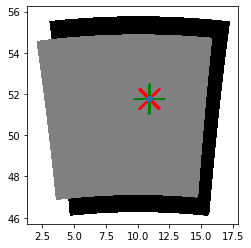

In [12]:
fig, ax = plt.subplots(1,1)
plt.plot(lons2, lats2, "k+", ms=1)
plt.plot(lons, lats, marker="+", lw=0, color="grey", ms=1)
plt.plot(lons[ids], lats[ids], "g+", ms=30)
plt.plot(lons2[ids2], lats2[ids2], "rx", ms=20)
locs.plot(ax=ax, markersize=10, zorder=10)


In [13]:
tarfs = glob.glob("data/rw/2021_repr/RW2017.002_*.tar.gz")
df21 = pd.DataFrame(columns=ids)
for tarf in tarfs:
    print(tarf)
    tar = tarfile.open(tarf)
    members = tar.getmembers()
    dtimes = []
    alldata = np.zeros((len(members),len(ids)))
    for i,member in enumerate(members):
        f=tar.extractfile(member)
        data, metadata = wradlib.io.read_radolan_composite(f)
        data[data==-9999.] = np.nan
        dtimes.append( metadata["datetime"] )
        alldata[i,:] = data.ravel()[ids2]              
    tar.close()
    tmp = pd.DataFrame(alldata, columns=ids, index=dtimes)
    df21 = pd.concat( [df21, tmp] )
df21 = df21.sort_index()

data/rw/2021_repr/RW2017.002_202102.tar.gz
data/rw/2021_repr/RW2017.002_202105.tar.gz
data/rw/2021_repr/RW2017.002_202106.tar.gz
data/rw/2021_repr/RW2017.002_202103.tar.gz
data/rw/2021_repr/RW2017.002_202109.tar.gz
data/rw/2021_repr/RW2017.002_202104.tar.gz
data/rw/2021_repr/RW2017.002_202112.tar.gz
data/rw/2021_repr/RW2017.002_202107.tar.gz
data/rw/2021_repr/RW2017.002_202110.tar.gz
data/rw/2021_repr/RW2017.002_202111.tar.gz
data/rw/2021_repr/RW2017.002_202108.tar.gz
data/rw/2021_repr/RW2017.002_202101.tar.gz


In [14]:
df = pd.concat( [df21, df22] ).sort_index()
for column in df.columns:
    df[column] = df[column].astype("float")
df.columns = pixelids

In [15]:
header="""# This file contains the hourly precipitation time series for each RADOLAN pixel ID.
# The RADOLAN pixel IDs are used as column headers and are mapped to each rover grid point in the file
# rover2radolan.csv. The locations of the RADOLAN pixel are also redundantly specified in the file 
# radolan-coords.csv. Datetime is in UTC and refers to the end of an hourly interval.
"""
with open("data/locs/radolan-extract.csv", "w") as f:
    f.write(header)
    df.to_csv(f, index=True, date_format="%Y-%m-%dT%H:%M:%S", 
              index_label="datetime", float_format="%.2f")

In [16]:
header="""# This file contains the locations (pixel center coordinates) of the RADOLAN pixels.
# 
# pixelid: ID of radolan pixel mapped to rover grid points (see also rover2radolan.csv and radolan-extract.csv)
# lon: longitude of radolan pixel (EPSG:4326)
# lat: latitude of radolan pixel (EPSG:4326)
"""
with open("data/locs/radolan-coords.csv", "w") as f:
    f.write(header)
    dfpixels = pd.DataFrame(np.c_[lons[ids], lats[ids]], index=df.columns, columns=["lon", "lat"] )
    df.to_csv(f, index=True, index_label="pixel_id", float_format="%.6f")

## Check against closest DWD precipitation gauge

In [18]:
fdwdgauges = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/recent/RR_Stundenwerte_Beschreibung_Stationen.txt"
dwdgauges = pd.read_fwf(fdwdgauges, encoding="ISO-8859-1", skiprows=2, names=["id", "from", "to", "elevation", "lat", "lon", "name","state"])
dwdgauges.head()

,id,from,to,elevation,lat,lon,name,state
0,3,19950901,20110401,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
1,20,20040814,20221205,432,48.9219,9.9129,Abtsgmünd-Untergröningen,Baden-Württemberg
2,29,20060110,20221205,260,49.7175,10.9101,Adelsdorf (Kläranlage),Bayern
3,44,20070401,20221205,44,52.9336,8.2370,Großenkneten,Niedersachsen
4,46,20060103,20221205,325,48.9450,12.4639,Aholfing,Bayern


In [19]:
tree = sp.KDTree(np.c_[dwdgauges.lon, dwdgauges.lat])
dd, ii = tree.query(np.c_[lons[ids], lats[ids]], k=1)
ii

array([823, 823, 823, 823, 823, 823, 823, 823, 823, 823, 823, 823, 823,
       823,  35,  35])

(51.6, 52.0)

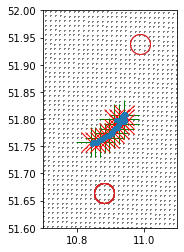

In [24]:
fig, ax = plt.subplots(1,1)
plt.plot(lons2, lats2, "k+", ms=1)
plt.plot(lons, lats, marker="+", lw=0, color="grey", ms=1)
plt.plot(lons[ids], lats[ids], "g+", ms=30)
plt.plot(lons2[ids2], lats2[ids2], "rx", ms=20)
locs.plot(ax=ax, markersize=10, zorder=10)
plt.plot(dwdgauges.lon[ii], dwdgauges.lat[ii], "ko", ms=20, mfc="None", mec="tab:red")
plt.xlim(10.7,11.1)
plt.ylim(51.6, 52)

In [59]:
subset = dwdgauges.iloc[np.unique(ii)]
subset

,id,from,to,elevation,lat,lon,name,state
35,213,20070501,20221205,170,51.9375,10.9897,Sargstedt,Sachsen-Anhalt
823,4878,20050201,20221205,504,51.6646,10.8811,Oberharz am Brocken-Stiege,Sachsen-Anhalt


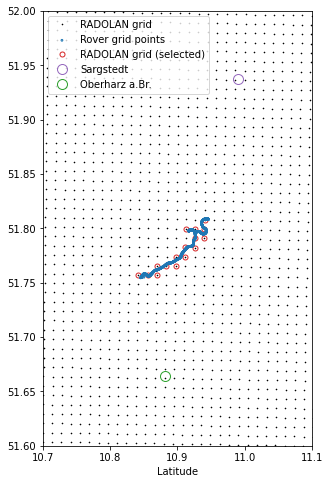

In [75]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_aspect("equal")
plt.plot(lons, lats, "kx", ms=1, label="RADOLAN grid")
locs.plot(ax=ax, marker="o", fc="None", ec="tab:blue", markersize=3, zorder=10, label="Rover grid points")
plt.plot(lons[ids], lats[ids], "go", ms=5, mfc="None", mec="tab:red", label="RADOLAN grid (selected)")
plt.plot(subset.loc[35, "lon"], subset.loc[35, "lat"], "ko", ms=10, mfc="None", mec="tab:purple", label="Sargstedt")
plt.plot(subset.loc[823, "lon"], subset.loc[823, "lat"], "ko", ms=10, mfc="None", mec="tab:green", label="Oberharz a.Br.")
plt.xlim(10.7,11.1)
plt.ylim(51.6, 52)
plt.xlabel("Longitude")
plt.xlabel("Latitude")
plt.legend()

In [40]:
rr1 = pd.read_csv("data/rr/stundenwerte_RR_04878_akt/produkt_rr_stunde_20210603_20221204_04878.txt", sep=";")
rr1.MESS_DATUM = pd.to_datetime(rr1.MESS_DATUM, format="%Y%m%d%H")
rr1 = rr1.set_index("MESS_DATUM")
rr1 = rr1[["  R1"]]
rr1.columns = ["depth"]

rr2 = pd.read_csv("data/rr/stundenwerte_RR_00213_akt/produkt_rr_stunde_20210603_20221204_00213.txt", sep=";")
rr2.MESS_DATUM = pd.to_datetime(rr2.MESS_DATUM, format="%Y%m%d%H")
rr2 = rr2.set_index("MESS_DATUM")
rr2 = rr2[["  R1"]]
rr2.columns = ["depth"]



In [103]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

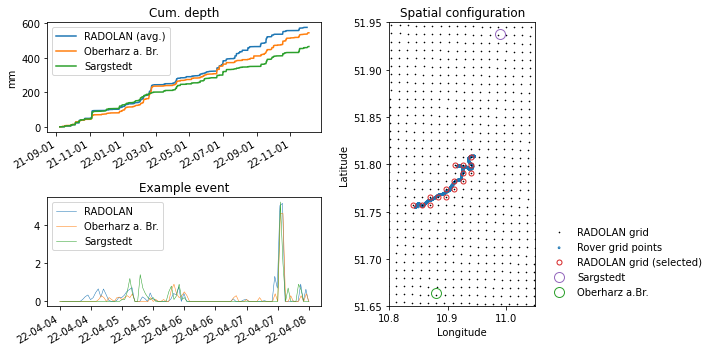

In [150]:
fig, ax = plt.subplot_mosaic([["11","2"],["21","2"]], figsize=(10,5), sharex=False)
plt.sca(ax["11"])
tstart = dt.datetime(2021,9,7)
tend = dt.datetime(2022,12,5)
tmp = df[tstart:tend]
plt.plot(tmp.index, tmp.mean(axis=1).cumsum(), label="RADOLAN (avg.)")
tmp = rr1[tstart:tend]
plt.plot(tmp.index, tmp.depth.cumsum(), label="Oberharz a. Br.")
tmp = rr2[tstart:tend]
plt.plot(tmp.index, tmp.depth.cumsum(), label="Sargstedt")
plt.legend()
plt.ylabel("mm")
plt.title("Cum. depth")
ax["11"].xaxis.set_major_formatter(DateFormatter("%y-%m-%d"))
plt.setp(plt.xticks()[1], rotation=30, ha='right')

plt.sca(ax["21"])
tstart = dt.datetime(2022,4,4)
tend = dt.datetime(2022,4,8)
tmp = df[tstart:tend]
plt.plot(tmp.index, tmp.mean(axis=1), label="RADOLAN", lw=0.5)
#for col in tmp.columns:
#    plt.plot(tmp.index, tmp[col], color="grey", lw=0.5, label="_n")
tmp = rr1[tstart:tend]
plt.plot(tmp.index, tmp.depth, label="Oberharz a. Br.", lw=0.5)
tmp = rr2[tstart:tend]
plt.plot(tmp.index, tmp.depth, label="Sargstedt", lw=0.5)
plt.legend()
ax["21"].xaxis.set_major_formatter(DateFormatter("%y-%m-%d"))
plt.setp(plt.xticks()[1], rotation=30, ha='right')
plt.title("Example event")


plt.sca(ax["2"])
ax["2"].set_aspect("equal")
plt.plot(lons, lats, "kx", ms=1, label="RADOLAN grid")
locs.plot(ax=ax["2"], marker="o", fc="None", ec="tab:blue", markersize=3, label="Rover grid points")
plt.plot(lons[ids], lats[ids], "go", ms=5, mfc="None", mec="tab:red", label="RADOLAN grid (selected)")
plt.plot(subset.loc[35, "lon"], subset.loc[35, "lat"], "ko", ms=10, mfc="None", mec="tab:purple", label="Sargstedt")
plt.plot(subset.loc[823, "lon"], subset.loc[823, "lat"], "ko", ms=10, mfc="None", mec="tab:green", label="Oberharz a.Br.")
plt.xlim(10.8,11.05)
plt.ylim(51.65, 51.95)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="lower right", bbox_to_anchor=(2.2, 0), frameon=False)
plt.title("Spatial configuration")

plt.tight_layout()
plt.savefig("data/locs/visual.pdf", dpi=300)